# アンケート分析

ここでは、本書に記載されたコードを pandasではなく polars を使って実現してみます。

テキストマイニングの最初の一歩として、アンケートの自由記述文の分析を行ってみましょう。

In [13]:
import polars as pl
okinawa = pl.read_excel('data/H18koe.xlsx')# , xlsx2csv_options={"NA":None})

In [14]:
okinawa.describe()

describe,Opinion,Region,Sex,Age,Satis
str,str,str,str,str,str
"""count""","""331""","""331""","""331""","""331""","""331"""
"""null_count""","""0""","""0""","""0""","""0""","""0"""
"""mean""",null,null,null,null,null
"""std""",null,null,null,null,null
"""min""","""*もう少し駐車場が多いといい...","""NA""","""NA""","""NA""","""NA"""
"""max""","""６日間のうち、２日間熱を出し...","""関東""","""男性""","""７０代""","""該当しない"""
"""median""",null,null,null,null,null


In [15]:
okinawa.head(3)

Opinion,Region,Sex,Age,Satis
str,str,str,str,str
"""海岸の美化・清掃 航空運賃...","""関東""","""男性""","""３０代""","""やや満足"""
"""花粉で悩んでいますので、今回...","""関東""","""女性""","""６０代""","""やや満足"""
"""空港→国際通りまでタクシーを...","""関東""","""男性""","""５０代""","""やや満足"""



データのレコード数（行数:RangeIndex）は331件で、5つの列(columns)があることが分かります。
各列の欠損データ数を確認してみましょう。ただし、もとのExcelファイルでは欠損値が文字列として "NA" と入力されています。
欠損値が含まれる行は、後の処理のために削除します。文字列として NA が含まれている行を削除するという処理をしても構わないのですが、
ここでは、あえていったん polars で欠損値を表す null に変換してから、削除してみましょう。

まず NA を確認してみましょう。`pl.any()` で、いずれかの列にNAが含まれてるレコードを抽出します。

In [16]:
okinawa.filter(
    pl.any(pl.col(pl.Utf8).str.contains("NA"))
).head(5)

Opinion,Region,Sex,Age,Satis
str,str,str,str,str
"""トータル的に満足した旅行でし...","""九州""","""女性""","""６０代""","""NA"""
"""開発、便利も必要ですが、美し...","""中部""","""NA""","""NA""","""大変満足"""
"""ラッシュは58号線の混雑がこ...","""中部""","""男性""","""７０代""","""NA"""
"""パンフレットに書いてあるとこ...","""中部""","""女性""","""NA""","""やや満足"""
"""・タクシー運転手がきっちりあ...","""九州""","""男性""","""４０代""","""NA"""


それでは NA を polarsで欠損値を表す null (None) に置き換えます。

In [17]:
okinawa = okinawa.select(
    pl.all().apply(lambda x: None if x == "NA" else x) 
)

欠損値がふまれる行を、列ごとに確認します。

In [18]:
okinawa.select(
    pl.all().is_null().sum()
)

Opinion,Region,Sex,Age,Satis
u32,u32,u32,u32,u32
0,3,4,4,20



欠損値が含まれるレコード（行）をデータから削除します。

`drop_nulls()` で、いずれかの列に欠損値が含まれているレコードは削除されます。


In [19]:
print('okinawa shape=', okinawa.shape)
df = okinawa.drop_nulls()
print('df shape = ', df.shape)
df.select(
    pl.all().is_null().sum()
)

okinawa shape= (331, 5)
df shape =  (304, 5)


Opinion,Region,Sex,Age,Satis
u32,u32,u32,u32,u32
0,0,0,0,0


やや冗長ですが、以下のように `pl.any()` と `is_not_null()` を使って欠損値を削除することもできます。

In [ ]:
# df = okinawa.filter(
#     pl.any(pl.all().is_not_null())
# )
# df



## 独立性の検定

さて、自由回答の分析に入る前に、選択肢への回答数について統計的な分析を試みてみましょう。たとえば、満足度に性別による違いはあるでしょうか。
polars で属性ごとの頻度をカウントするには`count()`を使います。


In [20]:
(
    df.groupby(["Sex", "Satis"]).count().sort(["Sex", "Satis"])
)

Sex,Satis,count
str,str,u32
"""女性""","""やや不満""",6
"""女性""","""やや満足""",78
"""女性""","""大変不満""",1
"""女性""","""大変満足""",90
"""男性""","""やや不満""",8
"""男性""","""やや満足""",64
"""男性""","""大変不満""",1
"""男性""","""大変満足""",54
"""男性""","""該当しない""",2


この集計結果をいわゆる分割表として表現するには `pivot()` の処理を重ねます。

In [21]:
cross_tab =df.groupby(["Sex", "Satis"]).count().sort(["Sex", "Satis"]).pivot(values="count", index="Sex", columns="Satis") 
print(cross_tab)

shape: (2, 6)
┌──────┬────────────┬────────────┬────────────┬────────────┬────────────┐
│ Sex  ┆ やや不満   ┆ やや満足   ┆ 大変不満   ┆ 大変満足   ┆ 該当しない │
│ ---  ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ ---        │
│ str  ┆ u32        ┆ u32        ┆ u32        ┆ u32        ┆ u32        │
╞══════╪════════════╪════════════╪════════════╪════════════╪════════════╡
│ 女性 ┆ 6          ┆ 78         ┆ 1          ┆ 90         ┆ null       │
│ 男性 ┆ 8          ┆ 64         ┆ 1          ┆ 54         ┆ 2          │
└──────┴────────────┴────────────┴────────────┴────────────┴────────────┘




こうしたクロス表において、そのセル（該当項目）への回答数の違いを調べる統計的に手法として、**独立性の検定**という方法があります。
**カイ自乗検定**ともいわれます。


カイ自乗値はカイ自乗分布という確率分布にしたがう数値です。カイ自乗分布はグラフで表すと以下のような図になります。



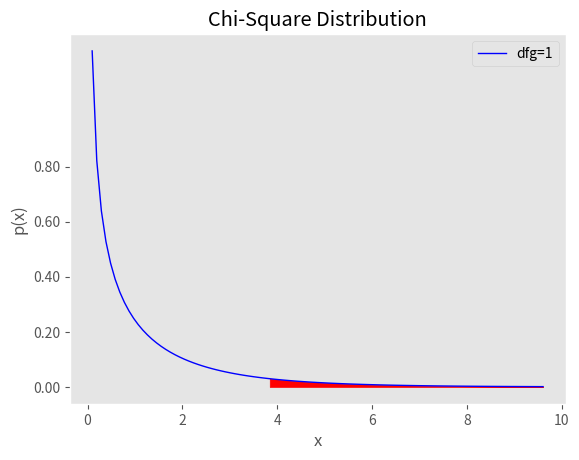

In [22]:
import math
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
## 自由度
dfg = 1

xc = chi2.ppf(0.95, dfg)
x = np.linspace(0, xc*2.5, 100)
y = chi2.pdf(x, dfg)
x2 = np.linspace(xc, xc*2.5, 20)
y2 = chi2.pdf(x2, dfg)

ymax = round(np.max(y), dfg)
ymax = 0.8

fig = plt.figure()
ax = fig.add_subplot()
ax.grid()
ax.plot(x, y, '-', color='blue', linewidth=1.0, label=f'dfg={dfg}')
ax.fill_between(x2, y2, '-', color='red')
ax.set_title('Chi-Square Distribution')
## Y 軸メモリをリスト内方法表記で生成
yticks = np.arange(0.0, ymax+0.1, 0.2)
yticklabels = ['%.2f' % x for x in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
## 下の1行はなくても良いが、実行しないと画像についての情報が出力される
plt.show()


Pythonで先ほどの中高生の回答からカイ自乗値を求めてみましょう。まず分割表を作成し、これに scipy ライブラリの `chi2_contingency()` を適用します。引数には分割表を表す変数を指定します。ここではさらに`correction=False`を指定しています。これはイェーツの補正を行わないことを指定しています。



In [14]:
from  scipy import stats
tab = [[18,17], [14,15]]
chi2, p, dof, ef =  stats.chi2_contingency(tab, correction=False)
print(f'カイ自乗値={chi2}, P値 ={p}, 自由度={dof}')
print('期待値 -----')
print(ef)

カイ自乗値=0.06305418719211822, P値 =0.8017322126569817, 自由度=1
期待値 -----
[[17.5 17.5]
 [14.5 14.5]]


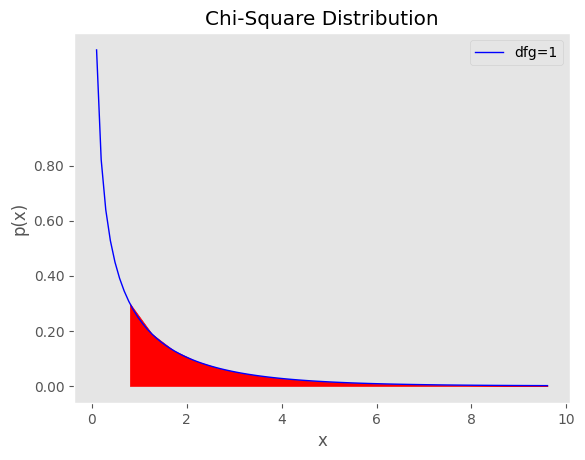

In [10]:
import math
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
plt.style.use('ggplot')

dfg = 1
xc = chi2.ppf(0.95, dfg)
x = np.linspace(0, xc*2.5, 100)
y = chi2.pdf(x, dfg)
x2 = np.linspace(0.8, xc*2.5, 20)
y2 = chi2.pdf(x2, dfg)
ymax = round(np.max(y), dfg)
ymax = 0.8

fig = plt.figure()
ax = fig.add_subplot()
ax.grid()
ax.plot(x, y, '-', color='blue', linewidth=1.0, label=f'dfg={dfg}')
ax.fill_between(x2, y2, '-', color='red')
ax.set_title('Chi-Square Distribution')
yticks = np.arange(0.0, ymax+0.1, 0.2)
yticklabels = ['%.2f' % x for x in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('p(x)')
## 下の1行はなくても良いが、実行しないと画像についての情報が出力される
plt.show()



カイ自乗分布は自由度によって形状が変わります。


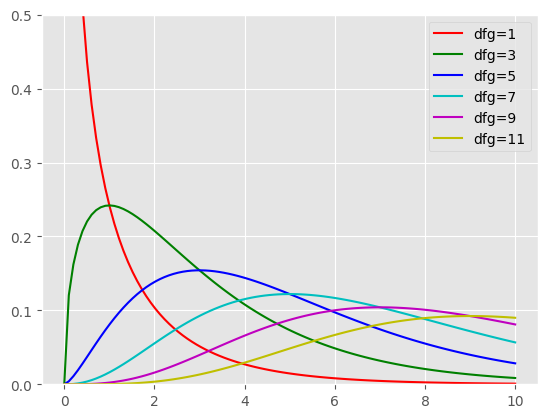

In [11]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
x = np.linspace(0, 10, 100)
fig,ax = plt.subplots(1, 1)
ax.set_ylim([0,.5])
## カラーの指定
colorlist = ['r', 'g', 'b', 'c', 'm', 'y']
## 自由度を設定
degrees_of_freedom=[1, 3, 5, 7, 9, 11]

for dgf, ls in zip(degrees_of_freedom, colorlist):
    ax.plot(x, stats.chi2.pdf(x,dgf), color = ls, label='dfg={}'.format(dgf))
ax.legend();
## 下の1行はなくても良いが、実行しないと画像についての情報が出力される
plt.show()





## 仮説検定

カイ自乗検定を行うには、本来、次のような手順を取る必要があります。まず仮説を立てます。古典的な統計的検定では2つの仮説が必要です。

帰無仮説と対立仮説を立ててから仮説検定を行い、確率の値（P値）にもとづいて判断を行うのが、カイ自乗検定に限らず、古典的な統計的検定の一般的な手順です。


## クロス表の作成とカイ自乗検定

沖縄観光データから作成した分割表にカイ自乗検定を適用してみましょう。

In [76]:
cross_tab

Sex,やや不満,やや満足,大変不満,大変満足,該当しない
str,u32,u32,u32,u32,u32
"""女性""",6,78,1,90,null
"""男性""",8,64,1,54,2


In [16]:
print('大変満足とやや満足の回答頻度')
print('--------------------')
print(cross_tab.select(['Sex', '大変満足', 'やや満足'], pl.sum(['大変満足', 'やや満足']).alias("合計")))

大変満足とやや満足の回答頻度
--------------------
shape: (2, 4)
┌──────┬────────────┬────────────┬──────┐
│ Sex  ┆ 大変満足   ┆ やや満足   ┆ 合計 │
│ ---  ┆ ---        ┆ ---        ┆ ---  │
│ str  ┆ u32        ┆ u32        ┆ u32  │
╞══════╪════════════╪════════════╪══════╡
│ 女性 ┆ 90         ┆ 78         ┆ 168  │
│ 男性 ┆ 54         ┆ 64         ┆ 118  │
└──────┴────────────┴────────────┴──────┘


In [17]:
print('大変不満とやや不満の回答頻度')
print('---------------------')
print(cross_tab.select(['Sex', '大変不満', 'やや不満'], pl.sum( ['大変不満', 'やや不満']).alias("合計")))

大変不満とやや不満の回答頻度
---------------------
shape: (2, 4)
┌──────┬────────────┬────────────┬──────┐
│ Sex  ┆ 大変不満   ┆ やや不満   ┆ 合計 │
│ ---  ┆ ---        ┆ ---        ┆ ---  │
│ str  ┆ u32        ┆ u32        ┆ u32  │
╞══════╪════════════╪════════════╪══════╡
│ 女性 ┆ 1          ┆ 6          ┆ 7    │
│ 男性 ┆ 1          ┆ 8          ┆ 9    │
└──────┴────────────┴────────────┴──────┘


カイ二乗検定では、回答数が極端に少ないセルがあると、カイ自乗値を正しく計算できない欠点があります。
そこで、いくつかのカテゴリは統合します。


In [18]:
X1 = cross_tab.select([pl.sum(['大変満足', 'やや満足']).alias("満足")])
print(X1)
X2 = cross_tab.select([pl.sum(['大変不満', 'やや不満']).alias("不満")])
print(X2)

shape: (2, 1)
┌──────┐
│ 満足 │
│ ---  │
│ u32  │
╞══════╡
│ 168  │
│ 118  │
└──────┘
shape: (2, 1)
┌──────┐
│ 不満 │
│ ---  │
│ u32  │
╞══════╡
│ 7    │
│ 9    │
└──────┘


In [19]:
cr_tb = pl.concat([X1, X2], how="horizontal")
cr_tb

満足,不満
u32,u32
168,7
118,9


In [20]:
from  scipy import stats
chi2, p, dfg, ef =  stats.chi2_contingency(cr_tb, correction=False)
print(f'カイ自乗値 = {chi2:.3f} P値 = {p:.3f} 自由度={dfg:.3f}')
print('--- 期待値 ---')
print(ef)

カイ自乗値 = 1.397 P値 = 0.237 自由度=1.000
--- 期待値 ---
[[165.72847682 120.27152318]
 [  9.27152318   6.72847682]]


## 自由記述文の形態素解析

さて、それではアンケートの自由記述文を分析してみましょう。



In [23]:
import my_mecab as my_tokenizer
words = []
for txts in df['Opinion']:
    lists  = my_tokenizer.tokens(txts)
    words.extend(lists)

ちなみに、形態素解析器として Janome を利用したいのであれば、次のようにします。

In [ ]:
import my_janome as my_tokenizer
words = []
for txts in df['Opinion']:
    lists  = my_tokenizer.tokens(txts)
    words.extend(lists)

ストップワードを用意します。

In [25]:
# 以下３行は、改めてストップワードをダウンロードする場合のコードです
# import urllib.request
# url = 'http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt'
# urllib.request.urlretrieve(url, 'data/stopwords.txt')

stopwords = []
with open('data/stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = [w.strip() for w in f]

stopwords.extend(['あの', 'この', 'ある', 'する', 'いる', 'できる', 'なる', 'れる', 'の', 'ら', 'しまう', 'は', '沖縄', '観光', '旅行', '思う'])
stopwords = set(stopwords)
len(stopwords)

327

合計で327個のストップワードが用意できました。それでは WordCloud を描いてみましょう。

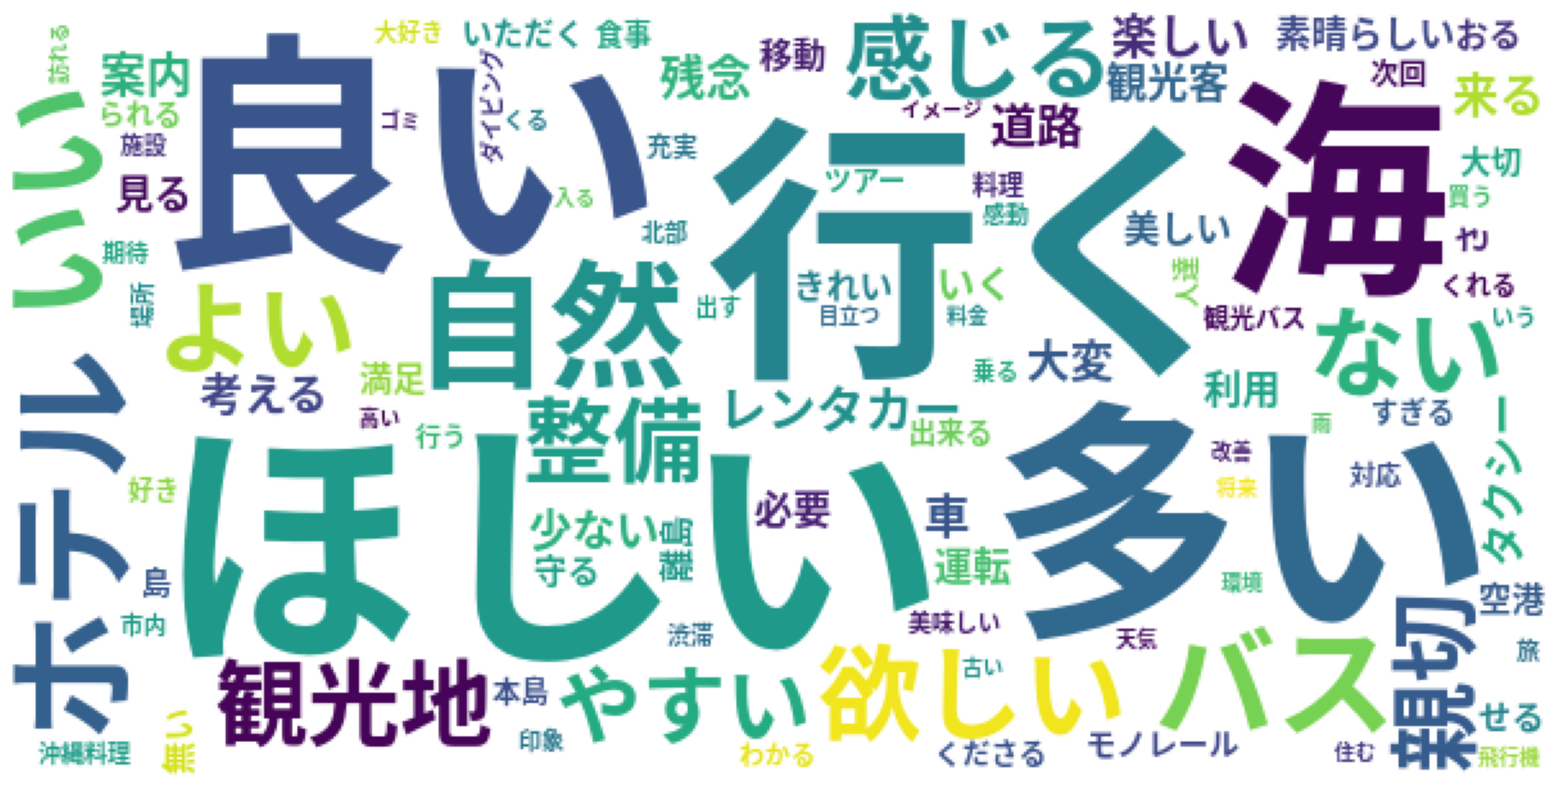

In [26]:
from  wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 10))
wd = WordCloud(background_color='white',
               ## フォントについては利用環境に合わせて指定
               ## 例えば 'C:\\WINDOWS\\FONTS\\MEIRYO.TTC'    ## メイリオ Windows
               ## '/Library/Fonts/ヒラギノ明朝 ProN W6.ttc' ## ヒラギノ macOS
               # font_path='/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf', for Ubuntu 20.04
               font_path='/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc',# for Ubuntu 22.10
               width=600, height=300, stopwords=stopwords, max_words=100).generate(' '.join(words))
plt.imshow(wd)
plt.axis('off')
plt.show()



## 対応分析

ここで性別と年齢の組み合わせた場合の回答数を確認してみましょう。




In [27]:
cross_tab =df.groupby(["Sex", "Age"]).count().sort(["Sex", "Age"]).pivot(values="count", index="Sex", columns="Age") 
print(cross_tab)

shape: (2, 8)
┌──────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│ Sex  ┆ １０代  ┆ ２０代  ┆ ３０代  ┆ ４０代  ┆ ５０代  ┆ ６０代  ┆ ７０代  │
│ ---  ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│ str  ┆ u32     ┆ u32     ┆ u32     ┆ u32     ┆ u32     ┆ u32     ┆ u32     │
╞══════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ 女性 ┆ 4       ┆ 37      ┆ 35      ┆ 15      ┆ 42      ┆ 36      ┆ 6       │
│ 男性 ┆ null    ┆ 9       ┆ 21      ┆ 27      ┆ 25      ┆ 33      ┆ 14      │
└──────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┴─────────┘


１０代と７０代の回答が非常に少ないことが分かります。そこで削除するか、あるいは近い水準（グループ）に統合することが考えられます。ここでは１０代 と２０代を、またを７０代と６０代を統合することにします。
まずデータフレームの２０代女性の自由記述文を形態素解析してみましょう。
`Sex` と `Age` を条件指定して、レコードを抽出します。


In [82]:
sub_data = df.filter( (pl.col('Sex')  == "女性") & (pl.col('Age') == '２０代'))
sub_data.head(3)

Opinion,Region,Sex,Age,Satis
str,str,str,str,str
"""気候が暖かくて住みやすく、沖...","""中部""","""女性""","""２０代""","""大変満足"""
"""国道の渋滞が解消されると移動...","""関東""","""女性""","""２０代""","""やや満足"""
"""沖縄大好きです！ホエールウォ...","""九州""","""女性""","""２０代""","""やや満足"""


In [83]:
import my_mecab as my_tokenizer

female_20 = []

for txts in sub_data['Opinion']:
    lists  = my_tokenizer.tokens(txts)
    female_20.extend(lists)

len(female_20)

679

これを、属性の組み合わせごとに実行すれば良いわけです。

In [28]:
import itertools
sex = ['女性', '男性']
age = ['１０代','２０代', '３０代', '４０代', '５０代', '６０代', '７０代']

words_dic = {}
temp_lists = []
for v1, v2 in itertools.product(sex, age):
    words_dic[v1+'_'+v2] = 'text'
words_dic

{'女性_１０代': 'text',
 '女性_２０代': 'text',
 '女性_３０代': 'text',
 '女性_４０代': 'text',
 '女性_５０代': 'text',
 '女性_６０代': 'text',
 '女性_７０代': 'text',
 '男性_１０代': 'text',
 '男性_２０代': 'text',
 '男性_３０代': 'text',
 '男性_４０代': 'text',
 '男性_５０代': 'text',
 '男性_６０代': 'text',
 '男性_７０代': 'text'}



では、属性の組み合わせによってデータフレームからサブセットを抽出し、形態素にかけます。なお、pandas の `query()` の引数内で変数を指定するには、先頭に `@` を置きます。


In [29]:
import my_mecab_stopwords as my_tokenizer
import itertools
sex = ['女性', '男性']
age = ['１０代','２０代', '３０代', '４０代', '５０代', '６０代', '７０代']
## ストップワードをリストとして読み込むか、あるいは以下のリストを使う
## stopwords = [ 'ある', 'いる', 'する', 'の', 'なる', 'は' , 'こと', '思う', 'よう', 'よい', 'られる', '沖縄', '観光']
words_dic = {}
temp_lists = []
for v1, v2 in itertools.product(sex, age):
    print(v1, v2)
    ## 属性の組み合わせでデータフレームから抽出
    sub_data = df.filter((pl.col('Sex')  ==  v1) & (pl.col('Age')  == v2))
    print(sub_data.shape)
    temp = []
    temp_lists = []
    for txts in sub_data['Opinion']:
        ## あるレコード（回答者）の記述分を形態素解析
        temp  = my_tokenizer.tokens(txts, stopwords_list=stopwords)
        ## その属性の形態素リストに追加
        temp_lists.extend(temp)
        ## stopwords を削除
    ## 属性ごとの形態素リストを辞書に登録
    words_dic[v1+'_'+v2] = temp_lists

女性 １０代
(4, 5)
女性 ２０代
(37, 5)
女性 ３０代
(35, 5)
女性 ４０代
(15, 5)
女性 ５０代
(42, 5)
女性 ６０代
(36, 5)
女性 ７０代
(6, 5)
男性 １０代
(0, 5)
男性 ２０代
(9, 5)
男性 ３０代
(21, 5)
男性 ４０代
(27, 5)
男性 ５０代
(25, 5)
男性 ６０代
(33, 5)
男性 ７０代
(14, 5)


In [30]:
words_dic['女性_１０代']

['道路',
 '車',
 '多い',
 '排気ガス',
 '臭い',
 'ひめゆりの塔',
 '糸数',
 '壕',
 '中心',
 'まわる',
 '丁寧',
 '説明',
 '手管',
 'さる',
 '大変',
 '助かる',
 'ショッピング',
 'モノレール',
 '利用',
 '旅',
 'レンタカー',
 '使う',
 '北の方',
 '海',
 'みる',
 'レンタカー',
 '使う',
 'わかる',
 'やすい',
 'バス',
 '使い方',
 '掲示板',
 'ステキ',
 '来る']

In [31]:
words_dic['女性_２０代'].extend(words_dic['女性_１０代'])
words_dic['女性_６０代'].extend(words_dic['女性_７０代'])
## 実際には男性_１０代に回答者はいない
words_dic['男性_２０代'].extend(words_dic['男性_１０代'])
words_dic['男性_６０代'].extend(words_dic['男性_７０代'])

In [32]:
words_dic.pop('女性_７０代')
words_dic.pop('女性_１０代')
words_dic.pop('男性_７０代')
words_dic.pop('男性_１０代')

[]

In [33]:
## この段階で男性_１０代の回答はないのでエラーとなる
words_dic['男性_１０代']

KeyError: '男性_１０代'

In [34]:
for i, j in words_dic.items():
    print(f'属性{i}, 形態素の延べ数={len(j)}')

属性女性_２０代, 形態素の延べ数=504
属性女性_３０代, 形態素の延べ数=531
属性女性_４０代, 形態素の延べ数=305
属性女性_５０代, 形態素の延べ数=611
属性女性_６０代, 形態素の延べ数=595
属性男性_２０代, 形態素の延べ数=95
属性男性_３０代, 形態素の延べ数=220
属性男性_４０代, 形態素の延べ数=330
属性男性_５０代, 形態素の延べ数=317
属性男性_６０代, 形態素の延べ数=560


In [35]:
corpus = list(words_dic.values())
x = map(lambda x : ' '.join(x), corpus)
print(x)


実は、`CountVectorizer()` そのものは、文書単語行列の作成に利用するオブジェクトを生成する関数（少し特殊な用語ですがコンストラクタともいいます）であり、実際にテキストデータに適用するには `fit_transform()` か、あるいは `fit()` と `transform()` に分けて実行します。`fit()` と `transform()` が別々に用意されているのは、一般にデータイエンス分野では、あるデータ集合に適用して学習された結果を使って、同様のデータ集合に適用するという作業を行うからです。`fit()` で今回のデータに基づくモデルを作成し、新しいデータは  `transform()` を使ってこのモデルに適用するのです。 ここでは、今回の分析結果を、改めて別のデータ集合に適用することはないので、手順を分けず `fit_transform()` で一気に実行してしまいます。
先ほどの map オブジェクト `x` をリストに変換して `fit_transform()` を適用します。



In [36]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern='(?u)\\b\\w+\\b',
                             lowercase=False, min_df=1/10,
                             max_features=50)
okinawa_dtm = vectorizer.fit_transform(list(x))
print(okinawa_dtm)

  (0, 8)	6
  (0, 27)	3
  (0, 46)	3
  (0, 47)	4
  (0, 25)	7
  (0, 41)	8
  (0, 31)	1
  (0, 34)	2
  (0, 10)	5
  (0, 18)	8
  (0, 1)	6
  (0, 6)	2
  (0, 23)	3
  (0, 30)	11
  (0, 49)	6
  (0, 33)	1
  (0, 38)	3
  (0, 9)	5
  (0, 11)	8
  (0, 16)	4
  (0, 14)	4
  (0, 42)	1
  (0, 28)	1
  (0, 0)	7
  (0, 29)	2
  :	:
  (9, 0)	2
  (9, 29)	3
  (9, 13)	2
  (9, 43)	5
  (9, 19)	3
  (9, 37)	3
  (9, 7)	3
  (9, 20)	3
  (9, 39)	10
  (9, 15)	1
  (9, 45)	1
  (9, 40)	2
  (9, 35)	2
  (9, 4)	3
  (9, 36)	4
  (9, 32)	2
  (9, 44)	6
  (9, 48)	1
  (9, 17)	3
  (9, 5)	2
  (9, 24)	7
  (9, 22)	7
  (9, 2)	6
  (9, 21)	3
  (9, 26)	3


ちなみに、疎行列特有のフォーマットを通常の行列に変換するには `toarry()` を使います。


In [53]:
# okinawa_dtm.toarray()

抽出された形態素の一覧を確認するには `get_feature_names_out()` を使います。



In [37]:
print(f'抽出された形態素数：{len(vectorizer.get_feature_names_out())}')

抽出された形態素数：50



## コレスポンデンス分析

ここでは属性と自由記述文（に出現した形態素セット）の関連性を調べるため、コレスポンデンス分析を実行してみます。**コレスポンデンス分析** （**対応分析**ともいいます）は、アンケート調査などで、被験者の回答と属性（年齢など）との相関を調べる手法として広く使われています。たとえば、髪の色と瞳の色の対応を（海外で）調べたデータがあるとします。髪についてはブロンドから黒まで 5 段階 (fair,red,medium,dark,black) が、また瞳については青から黒までの 4 段階(blue,light,medium,dark) の色合いが調べられています。


|瞳 / 髪     |fair    |red     |medium  |dark    |black   |
|--------|--------|--------|--------|--------|--------|
|blue    |326     |38      |241     |110     |3       |
|light   |688     |116     |584     |188     |4       |
|medium  |343     |84      |909     |412     |26      |
|dark    |98      |48      |403     |681     |85      |



これは「瞳の色」という項目と、「髪の色」という項目をクロスさせた表になっています。2 つの項目の相関については、先に紹介したカイ自乗分析でも判断をすることができます。しかし、それぞれの項目の水準（色の種類）が増えると、どの水準がどの水準と相関しているのかが、分かりにくくなります。コレスポンデンスではバイプロットというグラフを使って視覚的に確認できるのがメリットです。実際に分析をしてみましょう。ここではコレスポンデンス分析に prince ライブラリを利用します。

https://github.com/MaxHalford/prince

https://maxhalford.github.io/prince/ca/



In [2]:
import polars as pl
X = pl.DataFrame(
    {'eye':['blue', 'light', 'medium', 'dark'],
     'fair' : [326, 688, 343, 98],
     'red': [38, 116, 84, 48],
     'medium':[241, 584, 909, 403],
     'dark' : [110, 188, 412, 681],
     'black': [3, 4, 26, 85]
    }    
)
X

eye,fair,red,medium,dark,black
str,i64,i64,i64,i64,i64
"""blue""",326,38,241,110,3
"""light""",688,116,584,188,4
"""medium""",343,84,909,412,26
"""dark""",98,48,403,681,85


ここではコレスポンデンス分析に prince ライブラリを利用します。なお、prince ライブラリはバージョン0.9以降でメソッドのインターフェイスがかなり変更されています。そのため、少し前のバージョンを指定してインストールします。


https://github.com/MaxHalford/prince

https://maxhalford.github.io/prince/ca/

なお、prince は Anaconda には付属していません。別途 `pip` でインストールしてください。
prince ライブラリの `CA()` メソッドでコレスポンデンス分析を実行します。

なお、prince は Anaconda には付属していません。別途 `pip` でインストールしてください。

In [ ]:
!pip install prince==0.7.1

まず、分析のためのオブジェクトを生成します。

In [1]:
import prince
ca = prince.CA(
     n_components=4,
     n_iter=3,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
)

prince パッケージの描画ではデータフレームの index を参照します。polars のデータフレームは index という属性がないので、データフレームをpandasに変換した上で、index を設定することにします。

In [3]:
X_n = X.select(pl.col(pl.Int64)).to_pandas()
X_n.index =  ['Blue', 'Light', 'Medium', 'Dark']

X_n.columns.rename('Hair color', inplace=True)
X_n.index.rename('Eye color', inplace=True)
# X_n = X.select(pl.col(pl.Int64))
ca = ca.fit(X_n)

コレスポンデンス分析の考え方は、分割表で行と列それぞれの水準の関係の強さを、頻度とは別の指標で表現することです。



In [4]:
print('固有値の確認')
print(ca.eigenvalues_)
print('固有値の合計（イナーシャ）')
print(ca.total_inertia_)
print('それぞれの軸の割合')
print(ca.eigenvalues_/ ca.total_inertia_)# print(ca.explained_inertia_)

固有値の確認
[0.19924475202819086, 0.030086774100411807, 0.0008594813580620103, 2.008905878148878e-33]
固有値の合計（イナーシャ）
0.23019100748666482
それぞれの軸の割合
[8.65562709e-01 1.30703516e-01 3.73377469e-03 8.72712579e-33]




バイプロットを描きます。情報量の最大割合を占める2つの軸で、元データの行項目のスコアと、列項目のスコアを同時にプロットしています。


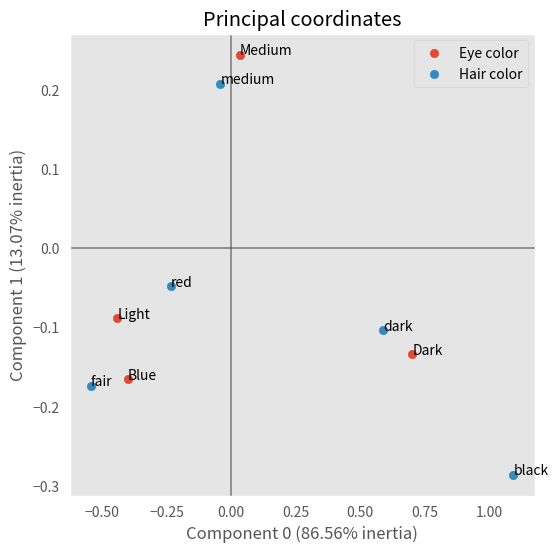

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
## 日本語フォントの準備
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Yu Gothic', 'Meirio', 'Hiragino Maru Gothic Pro', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

ax = ca.plot_coordinates(
     X=X_n,
     ax=None,
     figsize=(6, 6),
     x_component=0,
     y_component=1,
     show_row_labels=True,
     show_col_labels=True
)


この例では、髪の色と瞳の色という 2 つの項目（の水準）の相関を調べましたが、項目が 3 以上あることも考えられます。

試しに分析してみましょう。ここでは以下のような架空のデータを使って、 5 の形態素を項目とする文書単語行列を、購入者属性を関連付けてみます。


 
|                    |高機能              |スペース            |場所                |便利                |割高                |
|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|
|既婚(買う)          |4                   |2                   |2                   |3                   |1                   |
|既婚(買わない)      |2                   |8                   |9                   |3                   |7                   |
|独身(買う)          |6                   |1                   |2                   |6                   |2                   |
|独身(買わない)      |2                   |4                   |4                   |3                   |2                   |


この文書単語行列では「文書」に相当するのは属性で、例えば「既婚（買う）」は、回答者が既婚者で買うと回答したことを表します。この属性の回答者の自由記述文では「高機能」という形態素が全部で 4 回出現していることになります。ここでは、行項目の水準（属性）が 4 種類あり、列項目の水準（形態素）は 5 つあります。つまり 4 行 5 列の文書単語行列ということになります。まず、データフレーム形式のデータを用意しましょう。ここでは pandas ライブラリを使うことにします。引数として辞書を指定します。

In [7]:
import pandas as pd
cross = pd.DataFrame({'高機能':[4,2,6,2],
                      'スペース':[2,8,1,4],
                      '場所':[2,9,2,4],
                      '便利':[3,3,6,3],
                      '割高':[1,7,2,2]},
                     index = ['既婚(買う)', '既婚(買わない)', '独身(買う)', '独身(買わない)'])
cross

,高機能,スペース,場所,便利,割高
既婚(買う),4,2,2,3,1
既婚(買わない),2,8,9,3,7
独身(買う),6,1,2,6,2
独身(買わない),2,4,4,3,2


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
## 日本語フォントの設定
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Yu Gothic', 'Meirio', 'Hiragino Maru Gothic Pro', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
plt.style.use('ggplot')

In [9]:
import prince
ca = prince.CA(
    n_components=4,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
ca = ca.fit(cross)

In [10]:
print('固有値の確認')
print(ca.eigenvalues_)
print('固有値の合計（イナーシャ）')
print(ca.total_inertia_)
print('それぞれの軸の割合')
print(ca.eigenvalues_/ ca.total_inertia_)# print(ca.explained_inertia_)

固有値の確認
[0.20804616069545903, 0.01004437300260966, 0.003628448012262656, 3.3446067269378834e-35]
固有値の合計（イナーシャ）
0.2217189817103311
それぞれの軸の割合
[9.38332655e-01 4.53022692e-02 1.63650761e-02 1.50848912e-34]


バイプロットを描きます。

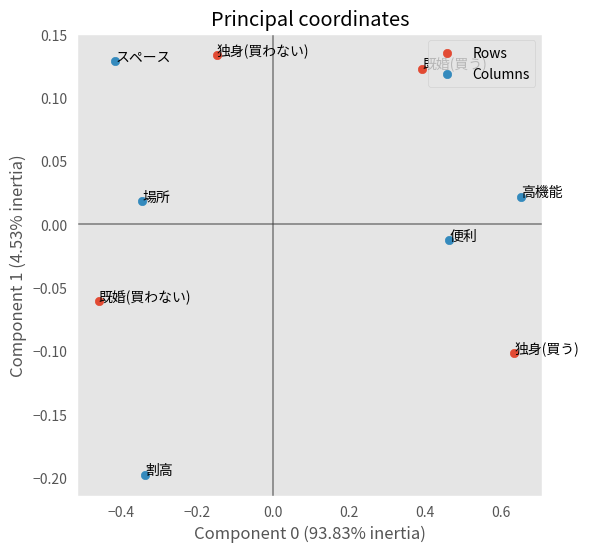

In [11]:
ax = ca.plot_coordinates(
    X=cross,
    ax=None,
    figsize=(6, 6),
    x_component=0,
    y_component=1,
    show_row_labels=True,
    show_col_labels=True
)

コレスポンデンス分析によって、回答者の属性と、回答自由記述文との関連性を、プロットで確認できるようになります。

前置きが長くなりましたが、それでは、沖縄観光自由記述文の回答傾向に、年齢あるいは性別による差があるかを確認してみましょう。

prince ライブラリを利用するため、pandas のデータフレームに変換します。


In [38]:
df2 = pd.DataFrame(okinawa_dtm.toarray(),
                   columns=vectorizer.get_feature_names_out(),
                   index=list(words_dic.keys()))
df2

,いい,いく,おる,きれい,さ,せる,ない,ほしい,やすい,よい,...,行う,行く,見る,親切,観光地,観光客,車,運転,道路,離島
女性_２０代,7,6,0,0,2,0,2,7,6,5,...,1,8,1,2,1,1,3,4,1,6
女性_３０代,8,1,2,5,2,3,3,8,3,3,...,2,14,1,3,4,4,2,3,3,2
女性_４０代,2,0,0,1,0,1,2,5,1,2,...,2,4,2,0,3,2,1,1,1,0
女性_５０代,4,1,1,1,3,4,2,11,4,3,...,0,9,2,5,1,2,6,1,1,0
女性_６０代,1,1,2,2,1,0,8,4,2,3,...,1,6,4,2,2,1,1,0,1,0
男性_２０代,0,0,0,0,2,1,0,3,2,0,...,0,0,0,0,0,1,2,2,0,0
男性_３０代,3,0,0,0,3,0,0,1,4,2,...,1,2,1,0,1,0,1,0,1,1
男性_４０代,0,2,1,3,1,0,1,3,0,1,...,2,4,0,1,1,3,0,1,1,1
男性_５０代,1,1,0,0,2,1,3,4,4,2,...,3,2,1,2,2,0,0,2,7,1
男性_６０代,2,2,6,0,3,2,3,3,1,4,...,2,6,2,5,6,1,1,0,1,1


たとえば、「ホテル」という単語が、属性ごとに何回出現しているかを確認してみましょう。

In [39]:
df2['ホテル']

女性_２０代     2
女性_３０代     6
女性_４０代     2
女性_５０代     6
女性_６０代    11
男性_２０代     1
男性_３０代     0
男性_４０代     0
男性_５０代     4
男性_６０代     2
Name: ホテル, dtype: int64

ちなみに、属性ごとに出現している形態素の数についても、調べてみましょう。

In [40]:
df2.sum(axis=1)

女性_２０代    147
女性_３０代    155
女性_４０代     64
女性_５０代    154
女性_６０代    139
男性_２０代     30
男性_３０代     58
男性_４０代     73
男性_５０代     99
男性_６０代    146
dtype: int64

In [41]:
import prince
ca = prince.CA(
    n_components=2,
    benzecri=False,
    n_iter=10,
    copy=True,
    check_input=True,
    engine='auto',
    random_state=42
)
okinawa_ca = ca.fit(df2)

2つの軸でどれだけ元データを説明できているかを確認します。

In [42]:
print('固有値の確認')
print(okinawa_ca.eigenvalues_)
print('固有値の合計（イナーシャ）')
print(okinawa_ca.total_inertia_)
print('それぞれの軸の割合')
print(okinawa_ca.eigenvalues_/ okinawa_ca.total_inertia_)# print(okinawa_ca.explained_inertia_)

固有値の確認
[0.11565182694677195, 0.09531489934604735]
固有値の合計（イナーシャ）
0.5897804291034836
それぞれの軸の割合
[0.19609302 0.16161082]


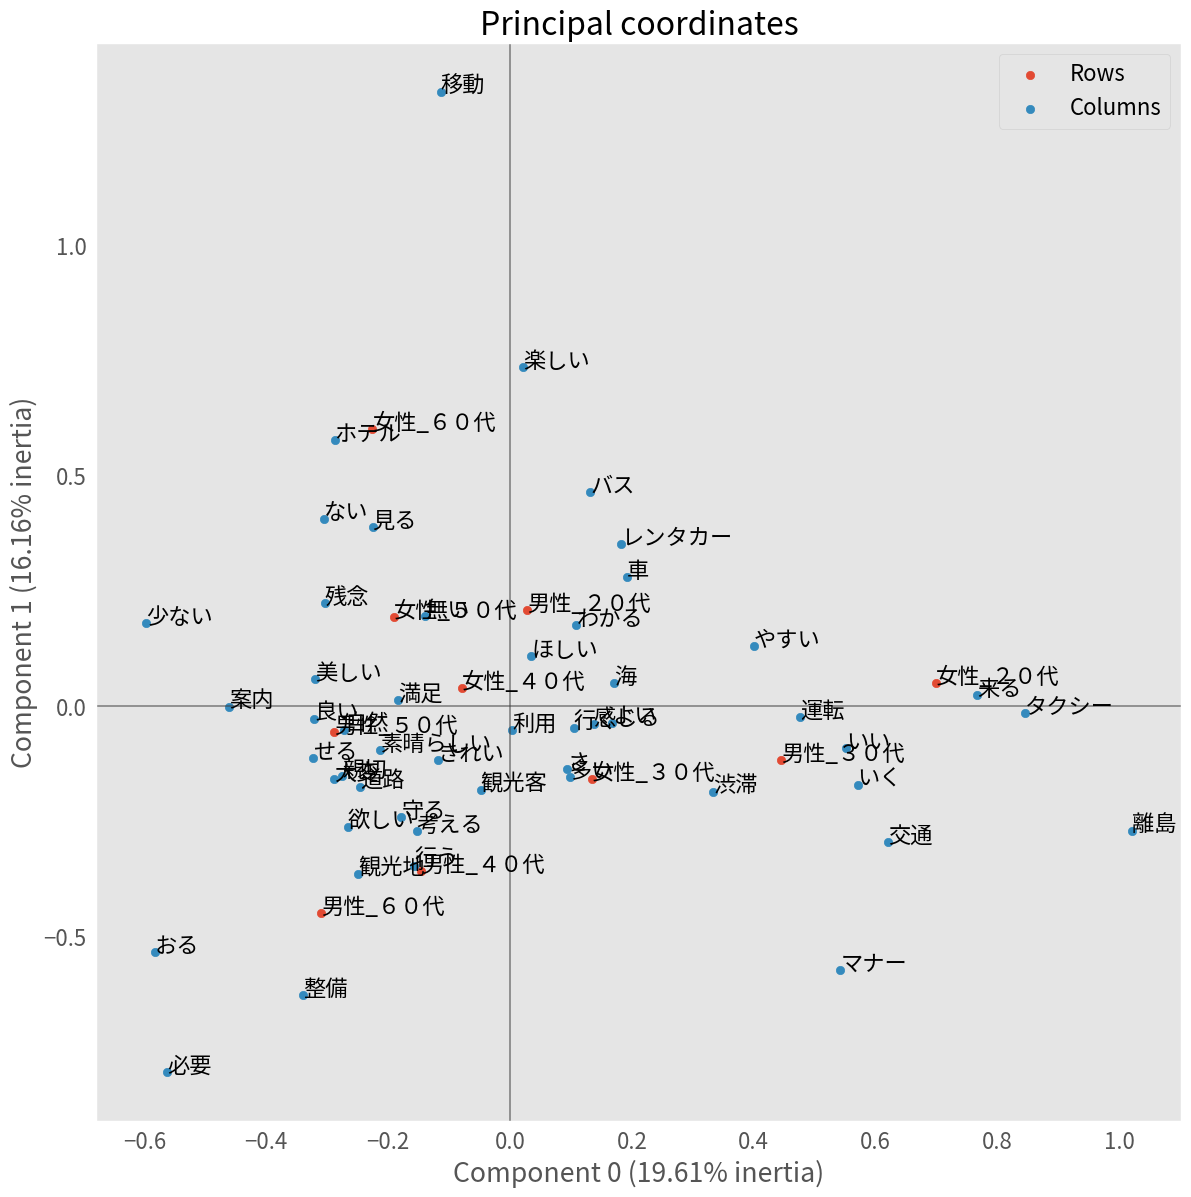

In [43]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 16
rcParams['font.sans-serif'] = ['Yu Gothic', 'Meirio', 'Hiragino Maru Gothic Pro', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']
 
ax = okinawa_ca.plot_coordinates(
    X=df2,
    ax=None,
    figsize=(14, 14),
    x_component=0,
    y_component=1,
    show_row_labels=True,
    show_col_labels=True
)

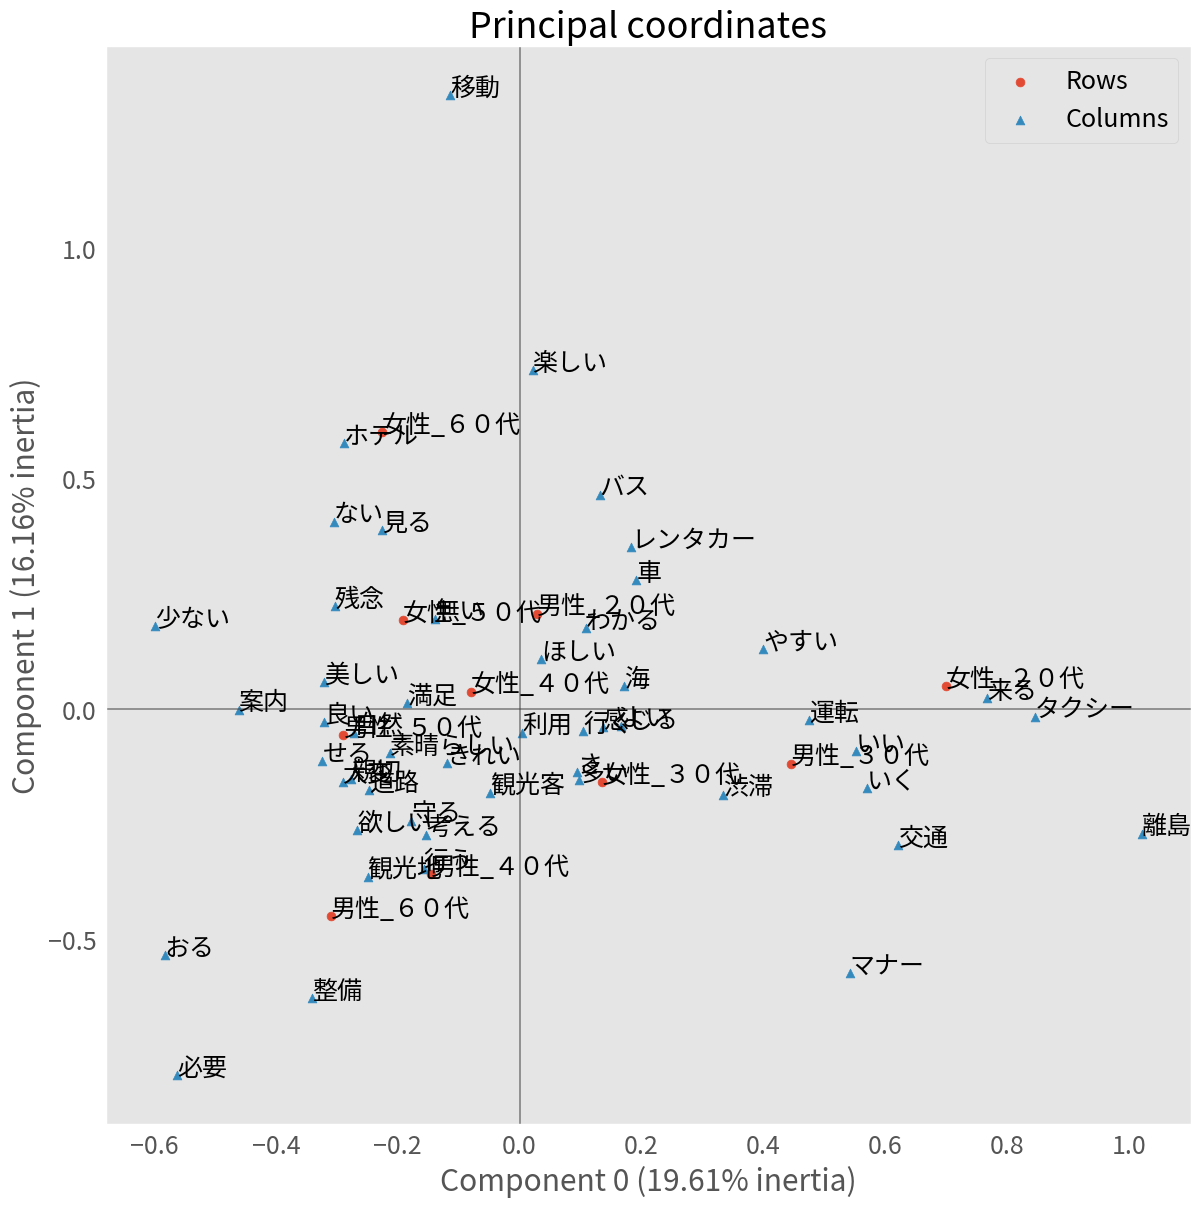

In [44]:
from matplotlib.markers import MarkerStyle
from matplotlib.collections import PathCollection
plt.rcParams['font.size'] = 18
fig, ax2 = plt.subplots(figsize=(14, 14))
okinawa_ca.plot_coordinates(
    X=df2,
    ax=ax2,
    x_component=0,
    y_component=1,
    show_row_labels=True,
    show_col_labels=True
)
markerlist = ['o', 'v', 'S', 'H']
for item, marker in zip(ax2.collections, markerlist): 
    if type(item) == PathCollection:        
        new_marker = MarkerStyle(marker)   
        item.set_paths((new_marker.get_path(),))
        item.set_sizes([10])
    
ax2.legend()

バイプロットでは、２０代と３０代の回答が右に、４０代以上の回答が左に、ほぼ分かれて分布しているのが分かります。また、上下でみると、女性の回答がほとんど上側に位置しているようです。
バイプロットでは原点には共通の特徴が集中し、原点から離れた位置に特徴的な要素が分布します。
